In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time as ti
from google.colab import drive
%matplotlib inline

In [ ]:
drive.mount('/content/gdrive')
!cd '/content/gdrive/My Drive/'


Mounted at /content/gdrive


# Data Preparation

In [ ]:
# Read the data From Google Drive
df = pd.read_csv("gdrive/My Drive/GCNIDS_Improvement/Fuzzy_dataset.csv")
df.columns = ['Timestamp','CAN_ID','Data byte','data_1','data_2','data_3','data_4','data_5','data_6','data_7','data_8','attack_flag']

# Cleaning The Data
df = df[['CAN_ID','Data byte','attack_flag']]
df['attack_flag'][df["attack_flag"] == "R"] = 0
df['attack_flag'][df["attack_flag"] == "T"] = 1
df['attack_flag'].fillna(0, inplace=True)
df['CAN_ID'].fillna("02b0", inplace=True)
df['Data byte'].fillna(8, inplace=True)

# allocate Unique ID int instead of Hex String
unique_ids = df['CAN_ID'].unique()

# Create a mapping dictionary
id_mapping = {id: idx + 1 for idx, id in enumerate(unique_ids)}

# Map hexadecimal IDs to integer values
df['CAN_ID'] = df['CAN_ID'].map(id_mapping)


df = df.drop(index=df.index[2000000:])
df = df.drop(index=df.index[:1000000])
df

<ipython-input-8-cf7653f52f18>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['attack_flag'][df["attack_flag"] == "R"] = 0
<ipython-input-8-cf7653f52f18>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['attack_flag'][df["attack_flag"] == "T"] = 1


,CAN_ID,Data byte,attack_flag
1000000,1,5,0
1000001,8,8,0
1000002,13,8,0
1000003,14,8,0
1000004,15,8,0
...,...,...,...
1999995,1503,8,1
1999996,10,8,0
1999997,11,8,0
1999998,451,8,1


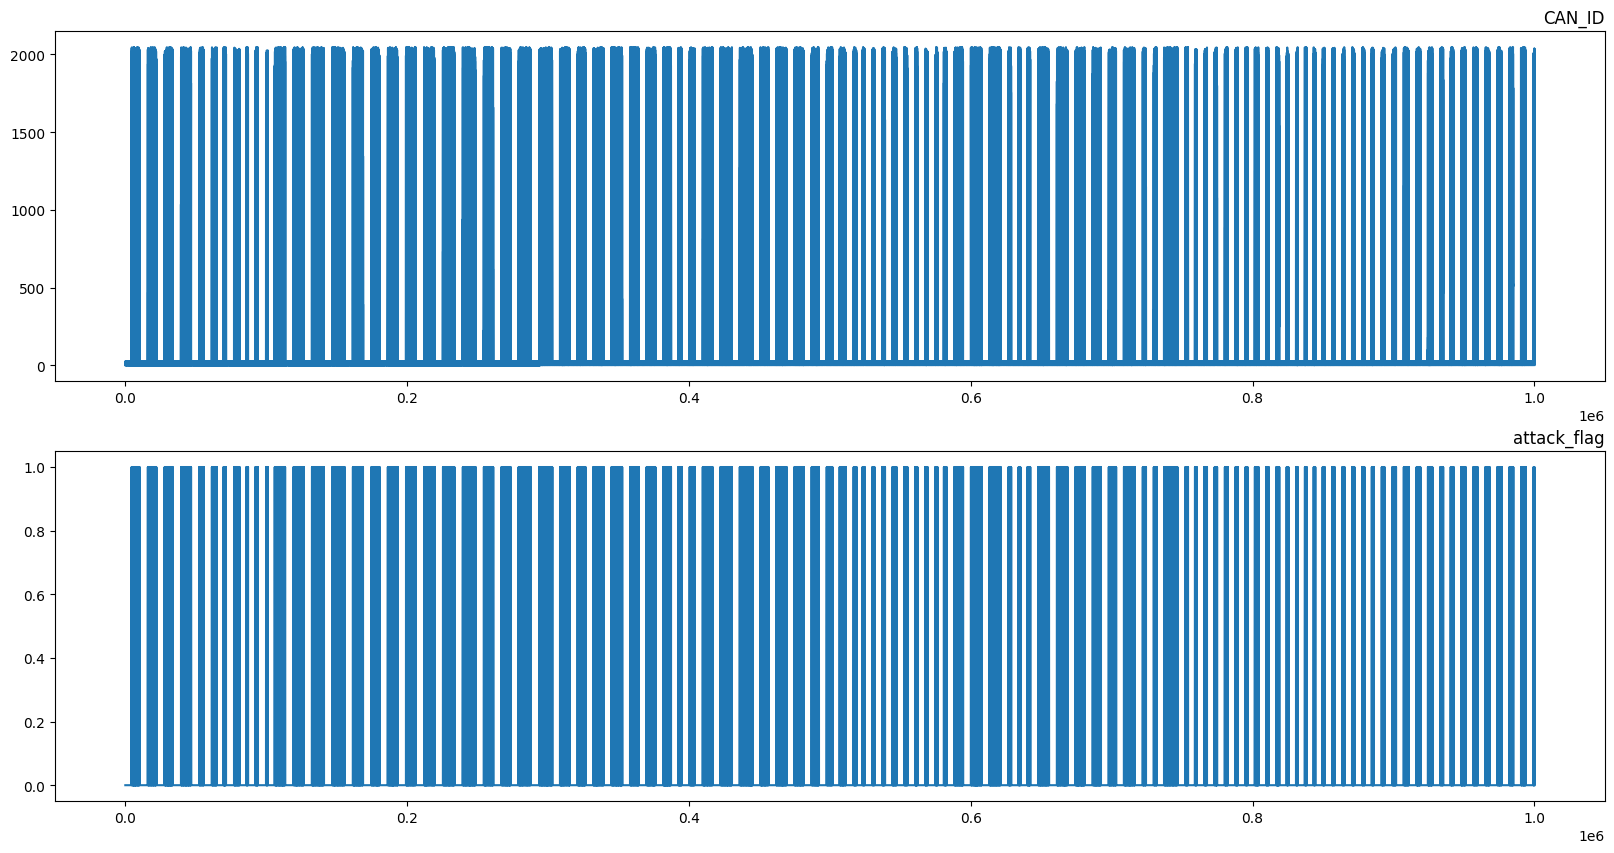

In [ ]:
values = df.values
groups = [0,2]
i = 1
plt.figure(figsize=(20,10))
for group in groups:
 plt.subplot(len(groups), 1, i)
 plt.plot(values[:, group])
 plt.title(df.columns[group], y=1, loc='right')
 i += 1
plt.show()

In [ ]:
from pandas import DataFrame
from pandas import concat
# Function for making time_series data
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 """
 Frame a time series as a supervised learning dataset.
 Arguments:
 data: Sequence of observations as a list or NumPy array.
 n_in: Number of lag observations as input (X).
 n_out: Number of observations as output (y).
 dropnan: Boolean whether or not to drop rows with NaN values.
 Returns:
 Pandas DataFrame of series framed for supervised learning.
 """
 n_vars = 1 if type(data) is list else data.shape[1]
 df = DataFrame(data)
 cols, names = list(), list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
 # put it all together
 agg = concat(cols, axis=1)
 agg.columns = names
 # drop rows with NaN values
 if dropnan:
    agg.dropna(inplace=True)
 return agg

In [ ]:
values = df.values
data = series_to_supervised(values,2,1)
# Cleaning data
data.drop(data.columns[[2,5]], axis=1, inplace=True)
print (data.head())
print (data.tail())

   var1(t-2)  var2(t-2)  var1(t-1)  var2(t-1)  var1(t)  var2(t)  var3(t)
2        1.0        5.0        8.0        8.0       13        8        0
3        8.0        8.0       13.0        8.0       14        8        0
4       13.0        8.0       14.0        8.0       15        8        0
5       14.0        8.0       15.0        8.0       16        8        0
6       15.0        8.0       16.0        8.0       17        8        0
        var1(t-2)  var2(t-2)  var1(t-1)  var2(t-1)  var1(t)  var2(t)  var3(t)
999995      670.0        8.0        9.0        8.0     1503        8        1
999996        9.0        8.0     1503.0        8.0       10        8        0
999997     1503.0        8.0       10.0        8.0       11        8        0
999998       10.0        8.0       11.0        8.0      451        8        1
999999       11.0        8.0      451.0        8.0        2        8        0


In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

values = data.values

# Splitting the data into train, val, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(values[:,:-1], values[:,-1], test_size=0.6, shuffle=False)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Reshape the data
X_train = X_train.reshape(X_train.shape[0], 3, 2)
X_test = X_test.reshape(X_test.shape[0], 3, 2)
X_val = X_val.reshape(X_val.shape[0], 3, 2)

# Display tensor shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")



X_train shape: (399999, 3, 2), y_train shape: (399999,)
X_test shape: (299999, 3, 2), y_test shape: (299999,)
X_val shape: (300000, 3, 2), y_val shape: (300000,)


# CNN model


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Generating random data for demonstration purposes
samples = X_train.shape[0]  # Number of samples
time_steps = 3  # Time steps (or sequence length)
features = 2  # Number of features

# Defining the model
model = Sequential()

# Convolutional layers
model.add(Conv1D(32, kernel_size=2, activation='relu', input_shape=(time_steps, features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=1, activation='relu'))
model.add(MaxPooling1D(pool_size=1))

# Flatten the output
model.add(Flatten())

# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Binary classification, so use sigmoid activation

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary to see the architecture and parameter count
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 32)             160       
                                                                 
 max_pooling1d (MaxPooling1  (None, 1, 32)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             2112      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8

In [ ]:
# Display tensor shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (399999, 3, 2), y_train shape: (399999,)
X_test shape: (299999, 3, 2), y_test shape: (299999,)
X_val shape: (300000, 3, 2), y_val shape: (300000,)


In [ ]:
# Train the model
history_cnn = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10
6250/6250 [==============================] - 41s 6ms/step - loss: 0.0705 - accuracy: 0.9860 - val_loss: 0.0338 - val_accuracy: 0.9926
Epoch 2/10
6250/6250 [==============================] - 35s 6ms/step - loss: 0.0376 - accuracy: 0.9917 - val_loss: 0.0230 - val_accuracy: 0.9948
Epoch 3/10
6250/6250 [==============================] - 35s 6ms/step - loss: 0.0332 - accuracy: 0.9928 - val_loss: 0.0232 - val_accuracy: 0.9949
Epoch 4/10
6250/6250 [==============================] - 36s 6ms/step - loss: 0.0313 - accuracy: 0.9932 - val_loss: 0.0235 - val_accuracy: 0.9956
Epoch 5/10
6250/6250 [==============================] - 35s 6ms/step - loss: 0.0298 - accuracy: 0.9935 - val_loss: 0.0186 - val_accuracy: 0.9960
Epoch 6/10
6250/6250 [==============================] - 35s 6ms/step - loss: 0.0289 - accuracy: 0.9940 - val_loss: 0.0189 - val_accuracy: 0.9962
Epoch 7/10
6250/6250 [==============================] - 35s 6ms/step - loss: 0.0291 - accuracy: 0.9938 - val_loss: 0.0208 - val_ac

In [ ]:
cnn_model = model
#cnn_model.save("gdrive/My Drive/GCNIDS_Improvement/CNN_model_Fuzzy.h5")

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
#cnn_model = load_model("gdrive/My Drive/GCNIDS_Improvement/CNN_model_Fuzzy.h5")

In [ ]:
predictions = cnn_model.predict(X_test)
# Assuming 'model' is your trained model for binary classification
threshold = 0.5  # Adjust the threshold as needed
predicted_classes = (predictions > threshold).astype(int)


9375/9375 [==============================] - 18s 2ms/step


In [ ]:
accuracy = accuracy_score(y_test, predicted_classes)
precision = precision_score(y_test, predicted_classes)
recall = recall_score(y_test, predicted_classes)
f1 = f1_score(y_test, predicted_classes)
print(f"Accuracy: {accuracy}")
print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"f1: {f1}")
# Train BiLSTM
# Define and train your BiLSTM model using TensorFlow/Keras

Accuracy: 0.9933833112777043
precision: 0.9845220429400605
recall: 0.9783290402060701
f1: 0.9814157717838051



# BiLSTM model

In [ ]:
# cleaning the Previous model
from keras import backend as K
K.clear_session()

In [ ]:
# Train BiLSTM
# Define and train your BiLSTM model using TensorFlow/Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Reshape, Flatten

# Define the model
model = Sequential()
inputs_shape = (X_train.shape[1], X_train.shape[2] )
# Add a Bidirectional LSTM layer
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape = inputs_shape))

# Add Flatten Layer to change the Output
model.add(Flatten())

# Add Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(16, activation='relu'))  # Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification


# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 3, 128)            34304     
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                                 
 dense (Dense)               (None, 128)               49280     
                                                                 
 dense_1 (Dense)             (None, 16)                2064      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 85665 (334.63 KB)
Trainable params: 85665 (334.63 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [ ]:
history_BiLSTM = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10
6250/6250 [==============================] - 65s 10ms/step - loss: 0.0187 - accuracy: 0.9968 - val_loss: 0.0129 - val_accuracy: 0.9978
Epoch 2/10
6250/6250 [==============================] - 60s 10ms/step - loss: 0.0171 - accuracy: 0.9970 - val_loss: 0.0128 - val_accuracy: 0.9979
Epoch 3/10
6250/6250 [==============================] - 59s 10ms/step - loss: 0.0167 - accuracy: 0.9971 - val_loss: 0.0121 - val_accuracy: 0.9980
Epoch 4/10
6250/6250 [==============================] - 60s 10ms/step - loss: 0.0166 - accuracy: 0.9971 - val_loss: 0.0122 - val_accuracy: 0.9979
Epoch 5/10
6250/6250 [==============================] - 60s 10ms/step - loss: 0.0164 - accuracy: 0.9971 - val_loss: 0.0123 - val_accuracy: 0.9980
Epoch 6/10
6250/6250 [==============================] - 59s 9ms/step - loss: 0.0162 - accuracy: 0.9971 - val_loss: 0.0121 - val_accuracy: 0.9980
Epoch 7/10
6250/6250 [==============================] - 52s 8ms/step - loss: 0.0161 - accuracy: 0.9971 - val_loss: 0.0121 - v

In [ ]:
BiLSTM_model = model

In [ ]:
#BiLSTM_model = load_model("gdrive/My Drive/GCNIDS_Improvement/BiLSTM_model.h5")

In [ ]:
predictions = BiLSTM_model.predict(X_test)
# Assuming 'model' is your trained model for binary classification
threshold = 0.5  # Adjust the threshold as needed
predicted_classes = (predictions > threshold).astype(int)

9375/9375 [==============================] - 24s 2ms/step


In [ ]:
accuracy = accuracy_score(y_test, predicted_classes)
precision = precision_score(y_test, predicted_classes)
recall = recall_score(y_test, predicted_classes)
f1 = f1_score(y_test, predicted_classes)
print(f"Accuracy: {accuracy}")
print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"f1: {f1}")
# Train BiLSTM
# Define and train your BiLSTM model using TensorFlow/Keras

Accuracy: 0.9976333254444182
precision: 0.9987734460504962
recall: 0.9879605778922612
f1: 0.9933375872682232


In [ ]:
BiLSTM_model = model
#BiLSTM_model.save("gdrive/My Drive/GCNIDS_Improvement/BiLSTM_model_Fuzzy.h5")

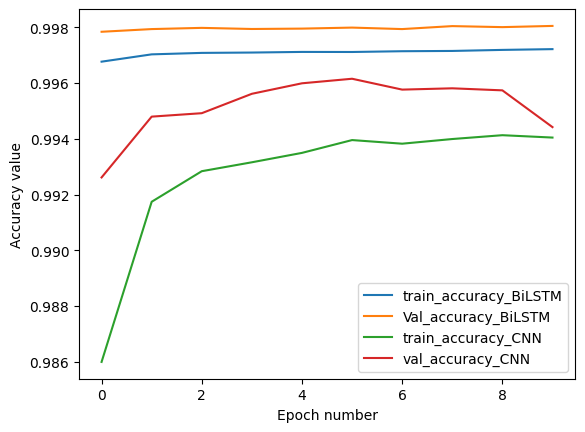

In [ ]:
# plot history
fig,ax = plt.subplots()
ax.plot(history_BiLSTM.history['accuracy'], label='train_accuracy_BiLSTM')
ax.plot(history_BiLSTM.history['val_accuracy'], label='Val_accuracy_BiLSTM')
ax.plot(history_cnn.history['accuracy'], label='train_accuracy_CNN')
ax.plot(history_cnn.history['val_accuracy'], label='val_accuracy_CNN')
ax.set_xlabel('Epoch number')
ax.set_ylabel('Accuracy value')
ax.legend()
plt.show()

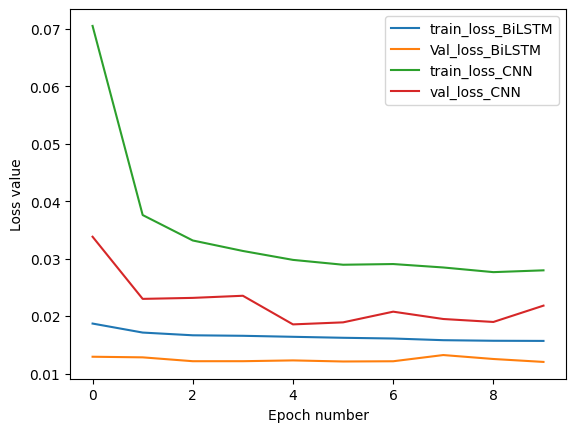

In [ ]:
# plot history
fig,ax = plt.subplots()
ax.plot(history_BiLSTM.history['loss'], label='train_loss_BiLSTM')
ax.plot(history_BiLSTM.history['val_loss'], label='Val_loss_BiLSTM')
ax.plot(history_cnn.history['loss'], label='train_loss_CNN')
ax.plot(history_cnn.history['val_loss'], label='val_loss_CNN')
ax.set_xlabel('Epoch number')
ax.set_ylabel('Loss value')
ax.legend()
plt.show()

# Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Reshape X_train if needed (if it's currently in shape (399999, 3, 2))
# X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

# Train the model
rf_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)  # Reshape X_train if needed

# Predict on test data
predictions = rf_model.predict(X_test.reshape(X_test.shape[0], -1))  # Reshape X_test if needed

# Evaluate the model (if desired)
accuracy = rf_model.score(X_test.reshape(X_test.shape[0], -1), y_test)  # Reshape X_test if needed
print(f"Accuracy: {accuracy}")

Accuracy: 0.9974999916666389


In [ ]:


# Assuming rf_model is your trained Random Forest model and predictions are made

# Accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

# Precision
precision = precision_score(y_test, predictions)
print(f"Precision: {precision}")

# Recall
recall = recall_score(y_test, predictions)
print(f"Recall: {recall}")

# F1-score
f1 = f1_score(y_test, predictions)
print(f"F1-Score: {f1}")


Accuracy: 0.9974999916666389
Precision: 0.9972512990436027
Recall: 0.9887258744913577
F1-Score: 0.9929702877495548


In [ ]:
# 3. Generate predictions
cnn_preds = cnn_model.predict(X_val)
lstm_preds = BiLSTM_model.predict(X_val)
rf_preds = rf_model.predict(X_val.reshape(X_val.shape[0], -1))


9375/9375 [==============================] - 25s 3ms/step


# Meta_Learner Model

In [ ]:
rf_preds = rf_preds.reshape(rf_preds.shape[0],1)
print (cnn_preds.shape)
print (lstm_preds.shape)
print (rf_preds.shape)


(300000, 1)
(300000, 1)
(300000, 1)


In [ ]:
# 4. Create meta-learner dataset
meta_features = np.concatenate((cnn_preds, lstm_preds, rf_preds), axis=1)
meta_dataset = np.concatenate((meta_features, X_val.reshape(X_val.shape[0], -1)), axis=1)  # Assuming features include more than just predictions


In [ ]:
# 5. Train meta-learner
from sklearn.linear_model import LogisticRegression
meta_learner = LogisticRegression()
meta_learner.fit(meta_dataset, y_val)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

# Ensemble Model

In [ ]:
import multiprocessing
# 6. Ensemble prediction
start1 = ti.time()
def Ensemble1(test) :
  cnn_test_preds = cnn_model.predict(test)
  lstm_test_preds = BiLSTM_model.predict(test)
  rf_test_preds = rf_model.predict(test.reshape(test.shape[0], -1))
  rf_test_preds = rf_test_preds.reshape(rf_test_preds.shape[0],1)
  meta_test_features = np.concatenate((cnn_test_preds, lstm_test_preds, rf_test_preds,  X_test.reshape(X_test.shape[0], -1)), axis=1)
  final_prediction = meta_learner.predict(meta_test_features)
  return final_prediction
start1 = ti.time()
final_prediction = Ensemble1 (X_test)
end1 = ti.time()

Time1 = end1 - start1

9375/9375 [==============================] - 25s 3ms/step


In [ ]:
Time1

63.66340374946594

In [ ]:
ytrue = y_test.tolist()
yhat = final_prediction.tolist()

In [ ]:
print (final_prediction.shape)
print (y_test.shape)
print  (f"Number of attacks in Actual data : {ytrue.count(1)}, Number of attack free in Actual data : {ytrue.count(0)} ")
print  (f"Number of attacks in predicted data : {yhat.count(1)}, Number of attack free in predicted data : {yhat.count(0)} ")

(299999,)
(299999,)
Number of attacks in Actual data : 53574, Number of attack free in Actual data : 246425 
Number of attacks in predicted data : 53041, Number of attack free in predicted data : 246958 


In [ ]:
# define our Confusion matrix beased on our info
def conf(yTrue,yPred):
  tp,tn,fp,fn = 0,0,0,0
  for i in range(len(yTrue)):
    if yTrue[i] == yPred[i] and yTrue[i] == 1:
      tp= tp+1

    elif yTrue[i] == yPred[i] and yTrue[i] == 0:
      tn = tn+1
    elif yTrue[i] == 0 and yPred[i] == 1:
      fp=fp+1
    else:
      fn=fn+1


  return np.array([[tp,fp],[fn,tn]])



my_conf = conf(ytrue,yhat)
print (f'TP:{my_conf[0][0]}')
print (f'FP:{my_conf[0][1]}')
print (f'FN:{my_conf[1][0]}')
print (f'TN:{my_conf[1][1]}')


TP:52950
FP:91
FN:624
TN:246334


In [ ]:
# Accuracy
accuracy = accuracy_score(y_test, final_prediction)
print(f"Accuracy: {accuracy}")

# Precision
precision = precision_score(y_test, final_prediction)
print(f"Precision: {precision}")

# Recall
recall = recall_score(y_test, final_prediction)
print(f"Recall: {recall}")

# F1-score
f1 = f1_score(y_test, final_prediction)
print(f"F1-Score: {f1}")


Accuracy: 0.9976166587221957
Precision: 0.9982843460719066
Recall: 0.9883525590771643
F1-Score: 0.9932936266003846


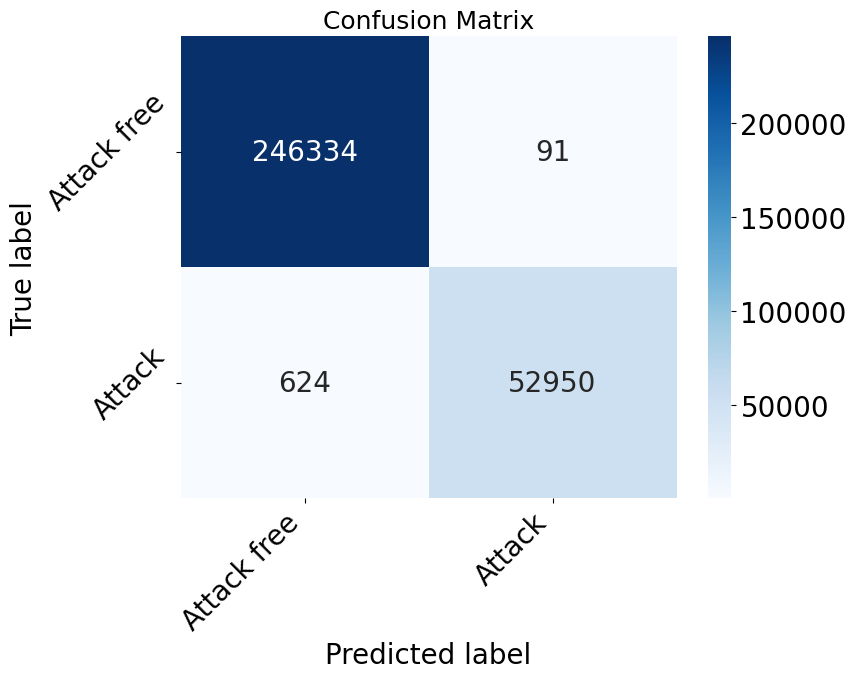

In [ ]:
# Confusion matrix
import seaborn as sns
conf_matrix = confusion_matrix(y_test, final_prediction)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Attack free', 'Attack'],
            yticklabels=['Attack free', 'Attack'])
plt.rcParams['font.size'] = 15
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.yticks(rotation = 45)
plt.xticks(rotation = 45, ha = 'right')
plt.title('Confusion Matrix')
plt.show()